In [1]:
import pandas as pd
import spacy
import json
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [25]:
def spacy_train(data, iterations):
    loss = []
    train_d = data
    nlp = spacy.blank('en')
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)

    for _, annotations in train_d:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.begin_training()
        for itn in range(iterations):
            print(str(itn))
            random.shuffle(train_d)
            losses = {}
            for text, annotations in train_d:
                nlp.update(
                    [text],
                    [annotations],
                    drop=0.2,
                    sgd=optimizer,
                    losses=losses)
            print(losses)
            loss.append(losses)
    return nlp, loss

In [26]:
filename = "../data/labeled_scraping_data_tags.json"
with open(filename, encoding='utf8') as train_data:
	train_j = json.load(train_data)

train = []
for data in train_j:
	ents = [tuple(entity) for entity in data['entities']]
	train.append((data['content'],{'entities':ents}))

# with open('{}'.format(filename.replace('json','txt')),'w', encoding='utf8') as write:
# 	write.write(str(train))
random.shuffle(train)
train, test = train[:60], train[60:]

In [ ]:
accuracy, precision, recall, f1_score, iterations, loss = [], [], [], [], [], []
for i in range(5, 15, 1):
    prdnlp, loss = spacy_train(train, i)
    TP, TN, FP, FN = 0, 0, 0, 0
    for item in test:
        doc = prdnlp(item[0])
        real_entities = {item[0][x[0]: x[1]].strip() for x in item[1]['entities']}
        nlp_entities = {ent.text for ent in doc.ents}
        if real_entities == nlp_entities:
            TP += len(real_entities)
        else:
            FP += len(nlp_entities.difference(real_entities))
            FN += len(real_entities.difference(nlp_entities))

    array = [[TN, FP],
            [FN, TP]]
    labels = ['True Neg','False Pos','False Neg','True Pos']
    categories = ['Zero', 'One']
    a, p, r, f = make_confusion_matrix(np.array(array),
                          group_names=labels,
                          categories=categories,
                          filename='../plots/ner_matrix_prefilter.png')
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    f1_score.append(f)
    iterations.append(i)

Statring iteration 0
{'ner': 249.38950834613982}
Statring iteration 1
{'ner': 140.00381542941724}
Statring iteration 2
{'ner': 55.1887655485225}
Statring iteration 3


g:\magisterka\automated-web-data-discovery-feature-basic_scraper\venv\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "1889 Powell St, Vancouver Tel: (604) 428-7975 Web:..." with entities "[(63, 74, 'RESTUARANT')]". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)
g:\magisterka\automated-web-data-discovery-feature-basic_scraper\venv\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "Wagamama has launched a new grab-and-go concept ca..." with entities "[(0, 9, 'RESTUARANT')]". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)
g:\magisterka\automated-web-data-discovery-feature-basic_scraper\venv\lib\site

In [21]:
# loss2
loss = [x['ner'] for x in loss]


39.16257228595825

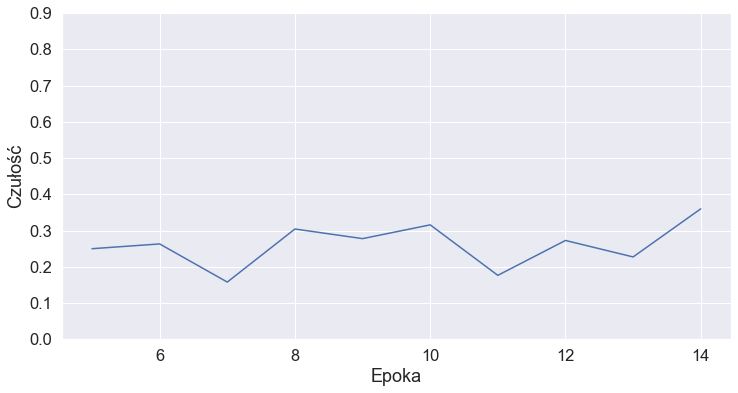

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (12,6)
# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.ylim(0.0, 0.9)
# precision = [x * 0.94 for x in precision]
data_plot = pd.DataFrame({"Epoka":iterations,
                          "Dokładność":accuracy,
                          "Precyzja":precision,
                          "Czułość":recall
                          })
sns.lineplot(x='Epoka', y='Czułość', data=data_plot)
plt.xlabel("Epoka")
plt.savefig('../plots/spacy_ner_recall_v2.png')

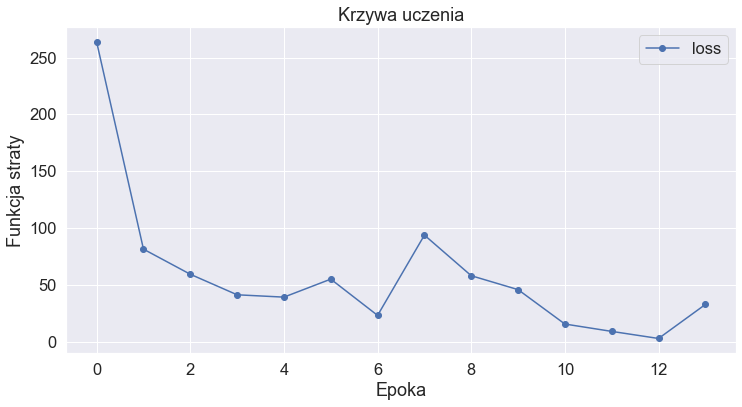

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss, 'b-o', label="loss")
# plt.plot(v_loss, 'r-o', label="validation loss")

plt.title("Krzywa uczenia")
plt.xlabel("Epoka")
plt.ylabel("Funkcja straty")
plt.legend()

plt.savefig('../plots/spacy_ner_loss_v2.png')

In [ ]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Another year, another new Bao opening.")
svg = displacy.render(doc, style="dep")
with open('POS_diagram.svg', 'w', encoding='utf8') as f:
    f.write(svg)

In [5]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          filename=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    filename:      Filename.
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1, 1] / sum(cf[:, 1])
            recall = cf[1, 1] / sum(cf[1, :])
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

    if filename:
        plt.savefig(filename)

    return accuracy, precision, recall, f1_score